# FYS-STK4155 - Project 1

## Introduction

This notebook contains code for the solution of all exercises (a - g), as well as visualizations of certain quantities of interest, such as the bias-variance trade-off, cross-validation and bootstrap methods. To solve the problems presented in the exercises, two classes are made, $\texttt{RegressionModel}$ and $\texttt{PolynomialModelSelector}$, which streamline regression and model selection, respectively.

### The Franke function

Here we define the Franke function, which we seek to approximate with a various regression models.

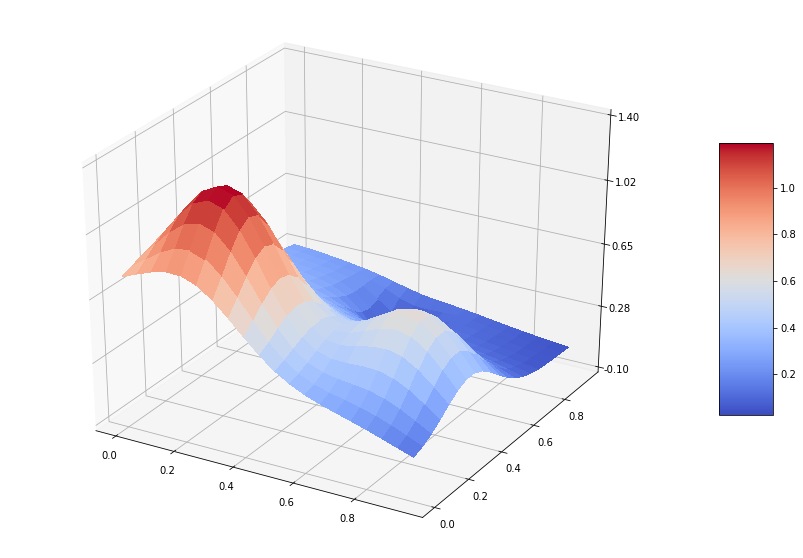

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import linear_model
from numba import jit

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection="3d")

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)

x, y = np.meshgrid(x,y)

def gaussian_noise(x, sd):
    return np.random.normal(0, sd, (x.shape))


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def noisy_franke(x,y, sd, scaler):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    z = term1 + term2 + term3 + term4
    
    noise = np.random.normal(0, sd, (z.shape))
    z +=  scaler *noise
    return z


sd = 0
scaler = 0.05
z = noisy_franke(x,y, sd, scaler)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
fig.colorbar(surf, shrink=0.5, aspect=5)


Here we define the $\texttt{RegressionModel}$ class which we use to perform regression. It has 3 different methods of finding the optimal $\beta$ coefficients, one employing ordinary least squares (OLS), another using the Ridge estimator, and the last one using the Lasso estimator from the $\texttt{sklearn}$ library. OLS and Ridge regression make use of singular value decomposition to find the inverse of the $\mathbf{X}^T \mathbf{X}$. This is slightly slower than $\texttt{numpy}$'s inverse method, but yields much more precise results for high-dimensional design matrices. Additionally, it has a method which automatically constructs a design matrix containing $n$ polynomial expressions of 2 features and their interactions.

In [2]:

class RegressionModel():
    

    
    def get_param_confidence(self, X, c):
        
        beta_var = np.linalg.inv(X.T @ X)
        
        us, ls = [], []
        
        for i, b in enumerate(self.beta):
            upper = b + (c * (self.variance* np.sqrt(beta_var[i, i])))
            lower = b - (c * (self.variance* np.sqrt(beta_var[i, i])))
            us.append(upper)
            ls.append(lower)

        return (us, ls)

    @staticmethod
    @jit(nopython=True)          
    def polynomial_design(degree, x, y):
        if len(x.shape) > 1:
            x, y = x.ravel(), y.ravel()
        

        n = len(x)
        p = int((degree+1)*(degree+2)/2)
        X = np.ones((n, p))

        for i in range(1, degree + 1):
            k = int((i)*(i+1)/2)
            for j in range(i+1):
                X[:,k+j] = (x**(i-j))*(y**j)
                          
            
        return X
    
    def scale(self, X, train= True):
        if train:
            self.X_scaler = StandardScaler()
            self.X_scaler.fit(X)
    
        X = self.X_scaler.transform(X)
        X[:, 0] = 1
        return X
    
    def OLS_fit(self, X, y):
        lmbd = 0  # no regularization
        inv_X = self.pseudo_inverse(X, lmbd = lmbd)  # get pseudo inverse of X using SVD
        

        self.beta =  inv_X @ X.T @ y
        self.y_tilde = X @ self.beta
        
    @staticmethod
    @jit(nopython=True)      
    def pseudo_inverse(X, lmbd):
        # regularize with (possibly zero) lambda
        A = X.T @ X
        A = A + (lmbd * np.identity(len(A)))
        
        # begin inversion using SVD
        U, s, VT = np.linalg.svd(A)
        D = np.zeros((len(U),len(VT)))  # diagonal
        
        for i in range(len(VT)):  # put in singular values
            D[i,i] = s[i]
            
        UT = U.T
        V = VT.T
        invD = np.linalg.inv(D)
        pseudo_inv = V @ (invD @ UT)
        
        return pseudo_inv
    
            
    def Ridge_fit(self, X, y, lmbd):
        inv_X = self.pseudo_inverse(X[:, 1:], lmbd = lmbd)  # get pseudoinverse with regularization, NB: intercept term is excluded in Ridge
        
        self.beta =  inv_X @ X[:, 1:].T @ y  # exclude intercept when computing beta
        self.beta = np.concatenate(([np.mean(y)], self.beta))  # add mean of y to beta
        self.y_tilde = X @ self.beta

    
        
    def Lasso_fit(self, X, y, lmbd):
        epsilon = 0.1
        lasso_mod = linear_model.Lasso(alpha=lmbd, fit_intercept=False, tol = epsilon)
        lasso_mod.fit(X, y)
        self.beta = lasso_mod.coef_

        self.y_tilde = X @ self.beta

        
    def MSE(self, y):
        mse = np.mean((y - self.y_tilde)**2)
        return mse
    
    def MSE_test(self, test_x, test_y):
        y_tilde = self.predict(test_x)
        mse = np.mean((test_y - y_tilde)**2)
        return mse
    
    def R_squared(self, X, y):
        y_tilde = self.predict(X)
        return 1 - (np.sum((y - y_tilde)**2) / np.sum((y - np.mean(y))**2))
    
    def predict(self, test_x):
        y_tilde = test_x @ self.beta
        return y_tilde
     

## Part a):

Here we fit the Franke function using OLS:

Set up test and training splits, as well as design matrix $\mathbf{X}$.

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ols_mod = RegressionModel()
degree = 5
x = x.ravel()
y = y.ravel()
z = z.ravel()

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)  # get train and test splits

# scale dependent variable
z_scaler = StandardScaler()
z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
z_test = z_scaler.transform(z_test.reshape(-1, 1))

z_train, z_test = z_train.ravel(), z_test.ravel()

X_train = ols_mod.polynomial_design(degree, x_train, y_train) 
X_train = ols_mod.scale(X_train)  # this method scales our design matrix according to the mean and sd of the train X
X_test = ols_mod.polynomial_design(degree, x_test, y_test)
X_test = ols_mod.scale(X_test, train = False)


Fit model and compute MSE

In [4]:
ols_mod.OLS_fit(X_train, z_train)
print(ols_mod.MSE(z_train))

0.026189320727902615


First we set the variance to 1 (an assumption based on the standard deviation in our Franke function). Now we can get the confidence intervals of the $\beta$ coefficients, $l = (\beta - c\sigma_\beta), u = (\beta + c\sigma_\beta) $ where $c=1.96$.

In [5]:
ols_mod.variance = 1
print(ols_mod.get_param_confidence(X_train, 1.96))

([0.10956733089748963, 10.110114709360426, 7.50267561356314, 1.5540971741566736, 6.112760947311368, 20.024286641156255, 79.80379919239836, 46.588939473539625, 38.87435823092112, 43.31720568698652, 55.39597845271735, 4.357958233495054, 23.687197755390716, 9.975784335461654, 92.54613125997705, 16.496770653892476, 18.93387043769897, 12.211286350800474, 7.203443922073195, 21.249648347500347, 6.375675942272405], [-0.10956733089748974, 0.9401585164619384, -1.8068948493640988, -48.08338741936002, -21.40286214161296, -30.707233687390836, -32.24689964738461, -7.047690769132856, -16.057020898595056, -72.69967103226395, -58.75100851231539, -49.56134275099758, -23.239413365898553, -45.76834260210077, -26.662092707284543, -26.71454731139066, -3.7409681022444925, -6.905940495049905, -12.757000318523456, -2.4406369019710503, -38.947875747847064])


Print MSE for the test data:

In [6]:
print(ols_mod.MSE_test(X_test, z_test))

0.02567602304080154


Print $R^2$ for the training data:

In [7]:
print(ols_mod.R_squared(X_train, z_train))

0.9738106792720974


Create a new gridmesh containing new testing points, for the purpose of plotting the fitted model:

In [8]:
x = np.arange(0, 1, 0.005)
y = np.arange(0, 1, 0.005)

x, y = np.meshgrid(x,y)
x, y = x.ravel(), y.ravel()
z = z.ravel()
X = ols_mod.polynomial_design(degree, x, y)
X = ols_mod.scale(X)


Get predictions for the new $\mathbf{X}$

In [9]:
y_hat = ols_mod.predict(X)

Sample the true values from the noiseless Franke function:

In [10]:
x = np.arange(0, 1, 0.005)
y = np.arange(0, 1, 0.005)
x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y)

Text(0.5, 0.92, 'Ground truth')

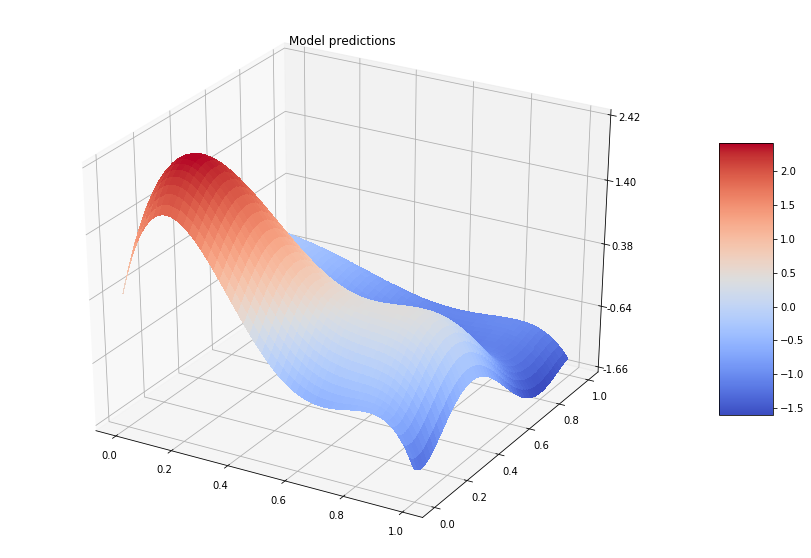

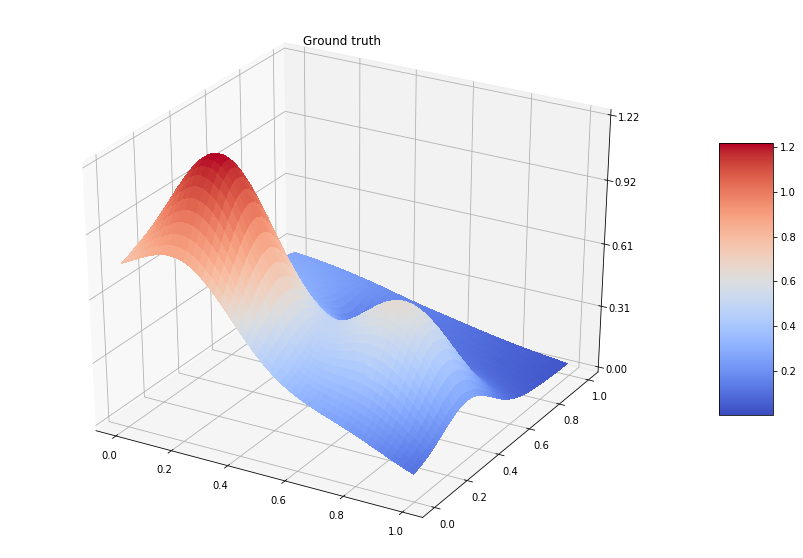

In [11]:
fig1 = plt.figure(figsize=(15, 10))
ax1 = fig1.gca(projection="3d")

surf = ax1.plot_surface(x, y, y_hat.reshape(200, 200), cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.

ax1.zaxis.set_major_locator(LinearLocator(5))
ax1.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
fig1.colorbar(surf, shrink=0.5, aspect=5)
ax1.set_title("Model predictions")



fig2 = plt.figure(figsize=(15, 10))
ax2 = fig2.gca(projection="3d")

surf2 = ax2.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.

ax2.zaxis.set_major_locator(LinearLocator(5))
ax2.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
fig2.colorbar(surf2, shrink=0.5, aspect=5)
ax2.set_title("Ground truth")

As can be seen, the fit is pretty good (first figure), despite the non-linearity of the Franke function.

## Part b)

Here we visualize the bias variance trade-off in the context of fitting the Franke function (using OLS), with polynomials of varying degrees. Here, the number of model parameters increase exponentially with the polynomial degree with which we fit the target function. Specifically, we illustrate how model complexity tends to improve (estimated) train mean squared error (MSE), whereas the test MSE generally tends to decrease with model complexity before increasing again when model complexity is so high that we overfit the training data. We use the bootstrap method to estimate the true MSE for both test and train data, as well as the variance of the estimated MSE. When analysing bias and variance, we also use the bootstrap method.

Text(0, 0.5, '')

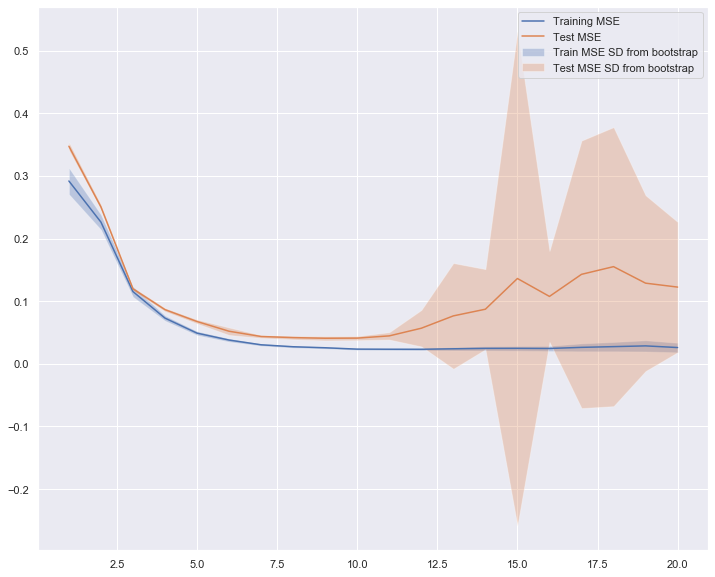

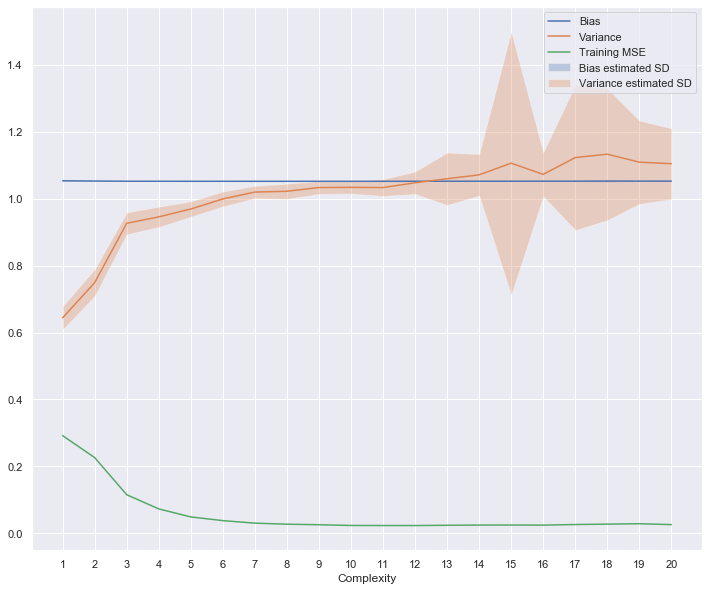

In [12]:
from sklearn.utils import resample
import numpy as np
import seaborn as sns
sns.set()

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

x, y = np.meshgrid(x, y)

sd = 1
scaler = 0.05
z = noisy_franke(x,y, sd, scaler)

max_poly_degree = 20

f, ax = plt.subplots(1, 1, figsize=(12, 10))
f1, ax1 = plt.subplots(1, 1, figsize=(12, 10))

# create empty arrays where we'll store data of interest
train_error = np.zeros(max_poly_degree)
test_error = np.zeros(max_poly_degree)
complexity = np.zeros(max_poly_degree)
test_mse_var = np.zeros(max_poly_degree)
train_mse_var = np.zeros(max_poly_degree)
beta_var = np.zeros(max_poly_degree)
bias = np.zeros(max_poly_degree)
bias_var = np.zeros(max_poly_degree)

errors = np.zeros(max_poly_degree)

variance = np.zeros(max_poly_degree)
var_var = np.zeros(max_poly_degree)

polydegree = np.zeros(max_poly_degree)


bootstrap_n = 100
################


x = x.ravel()
y = y.ravel()
z = z.ravel()
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.333, shuffle=True)



z_scaler = StandardScaler()
z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
z_test = z_scaler.transform(z_test.reshape(-1, 1))

z_train, z_test = z_train.ravel(), z_test.ravel()


for degree in range(1, max_poly_degree + 1):
    mod = RegressionModel()
  
    X_train = mod.polynomial_design(degree, x_train, y_train)
    X_train = mod.scale(X_train)
    X_test = mod.polynomial_design(degree, x_test, y_test)
    X_test = mod.scale(X_test, train = False)
    
    error = np.zeros(bootstrap_n)
    biases = np.zeros(bootstrap_n)
    variances = np.zeros(bootstrap_n)
    train_mse = np.zeros(bootstrap_n)
    test_mse = np.zeros(bootstrap_n)
    
    for i in range(bootstrap_n):
        X_, z_ = resample(X_train, z_train)
        mod.OLS_fit(X_, z_)
        train_MSE = mod.MSE(z_)
        test_MSE = mod.MSE_test(X_test, z_test)
        train_mse[i] = train_MSE
        test_mse[i] = test_MSE
        
        z_preds = mod.predict(X_test)
        biases[i] = np.mean((z_test - np.mean(z_preds))**2)
        variances[i] = np.var(z_preds)

    
    train_mse_var[degree - 1] = np.var(train_mse)
    test_mse_var[degree - 1] = np.var(test_mse)
    train_error[degree - 1] = np.mean(train_mse)#train_MSE
    test_error[degree - 1] = np.mean(test_mse)#test_MSE 
    complexity[degree - 1] = degree
    
    bias[degree-1] = np.mean(biases)
    bias_var[degree-1] = np.var(biases)
    variance[degree-1] = np.mean(variances)
    var_var[degree-1] = np.var(variances)
    errors[degree-1] = np.mean(train_mse)
    

train_mse_var = np.sqrt(train_mse_var)
test_mse_var = np.sqrt(test_mse_var) 
bias_var = np.sqrt(bias_var)
var_var = np.sqrt(var_var)

# first plot
ax.plot(complexity, train_error, label="Training MSE")
ax.plot(complexity, test_error, label="Test MSE")
ax.fill_between(complexity, train_error+ train_mse_var, train_error - train_mse_var, label="Train MSE SD from bootstrap", alpha=0.3)
ax.fill_between(complexity, test_error+ test_mse_var, test_error - test_mse_var, label="Test MSE SD from bootstrap", alpha=0.3)
ax.legend()
plt.xticks(np.arange(1, max_poly_degree+1))
plt.xlabel("Complexity")
plt.ylabel("MSE")

# second plot
ax1.plot(complexity, bias, label="Bias")
ax1.plot(complexity, variance, label="Variance")
ax1.plot(complexity, errors, label= "Training MSE")
ax1.fill_between(complexity, bias + bias_var, bias-bias_var, label="Bias estimated SD", alpha=0.3)
ax1.fill_between(complexity, variance + var_var, variance-var_var, label="Variance estimated SD", alpha=0.3)
ax1.legend()
plt.xticks(np.arange(1, max_poly_degree+1))
plt.xlabel("Complexity")
plt.ylabel("")


As can be seen in the first plot, test MSE decreases monotonically until the model contains a polynomial expansions up to degree 10, after which MSE starts to increase, indicating that we are overfitting. In the second plot we see the variance increasing with complexity. Moreover, the variance of the estimated variance (obtained from 100 bootstraps) increases as well, demonstrating the volatility and instability of the predictor coefficients at high model complexity. Indeed, when we use a polynomial of degree 30, we have $30^2 = 900$ parameters.

## Part c)

Here we take a look at the bias variance trade-off with cross-validation as well.

In [13]:
# define data again:
x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)
x, y = np.meshgrid(x, y)

sd = 1
scaler = 0.05
z = noisy_franke(x,y, sd, scaler)
x = x.ravel()
y = y.ravel()
z = z.ravel()

n = len(z)
k = 5  # five folds
# organize xyz in k random sets:
kn = int(n/k)  # make sure n is divisible by k
indices = np.random.choice(n, size=n, replace=False)

folds = np.zeros((k, kn), dtype=int)
for i in range(k):
    folds[i, :] = indices[i*kn: kn + (i*kn)]
    

In [14]:
max_poly = 30

MSE_train = np.zeros((k, max_poly))
MSE_test = np.zeros((k, max_poly))
complexity = np.zeros(max_poly)
for i in range(k):
    x_train = np.delete(x, folds[i, :])
    y_train = np.delete(y, folds[i, :])
    z_train = np.delete(z, folds[i, :])
    
    x_test = x[folds[i, :]]
    y_test = y[folds[i, :]]
    z_test = z[folds[i, :]]
    
    z_scaler = StandardScaler()
    z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
    z_test = z_scaler.transform(z_test.reshape(-1, 1))
    
    z_train, z_test = z_train.ravel(), z_test.ravel()
    
    for degree in range(1, max_poly + 1):
        mod = RegressionModel()

        X_train = mod.polynomial_design(degree, x_train, y_train)
        X_train = mod.scale(X_train)
        X_test = mod.polynomial_design(degree, x_test, y_test)
        X_test = mod.scale(X_test, train=False)
 
        mod.OLS_fit(X_train, z_train)
        train_MSE = mod.MSE(z_train)
        test_MSE = mod.MSE_test(X_test, z_test)
        
        MSE_train[i, degree - 1] = train_MSE
        MSE_test[i, degree - 1] = test_MSE
        complexity[degree - 1] = degree 
    
 

Text(0, 0.5, 'Cross validated MSE')

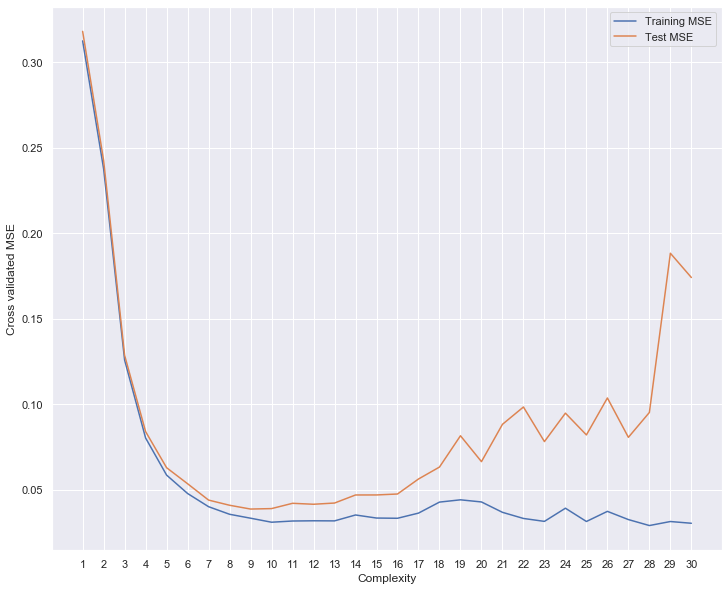

In [15]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

cv_train_error = np.mean(MSE_train, axis = 0)
cv_test_error = np.mean(MSE_test, axis = 0)

ax.plot(complexity, cv_train_error, label="Training MSE")
ax.plot(complexity, cv_test_error, label="Test MSE")
ax.legend()
plt.xticks(np.arange(1, max_poly+1))
plt.xlabel("Complexity")
plt.ylabel("Cross validated MSE")


As can be seen, comparable results are obtained with the cross-validation method.

## Part d)

Here we perform the same bootstrap and cross-validation analysis applied to Ridge regression. We look at the effect of different values of $\lambda$ on predictive variance, bias, train MSE and test MSE.

### 1: Bootstrap

<ipython-input-2-6ddd4b1f72fb>:59: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  A = X.T @ X
C:\Users\Tankred\Anaconda3\AnacondaDistributor\envs\tensor\lib\site-packages\numba\core\typing\npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


Text(0, 0.5, '')

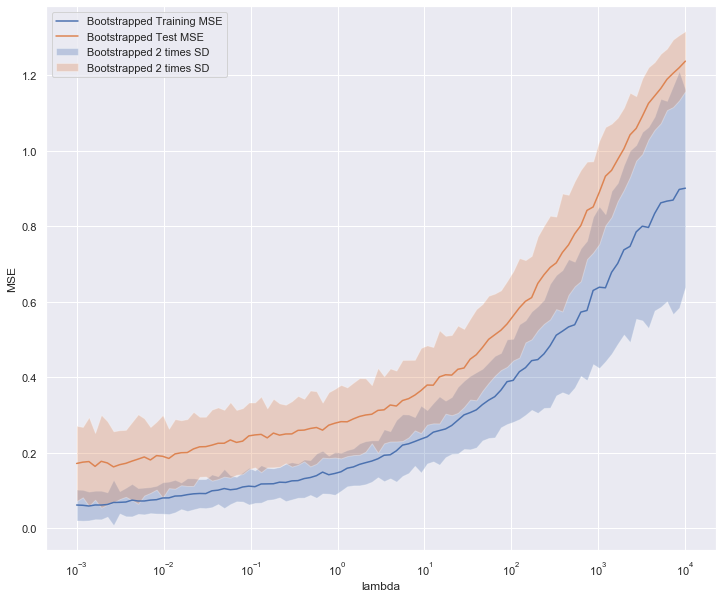

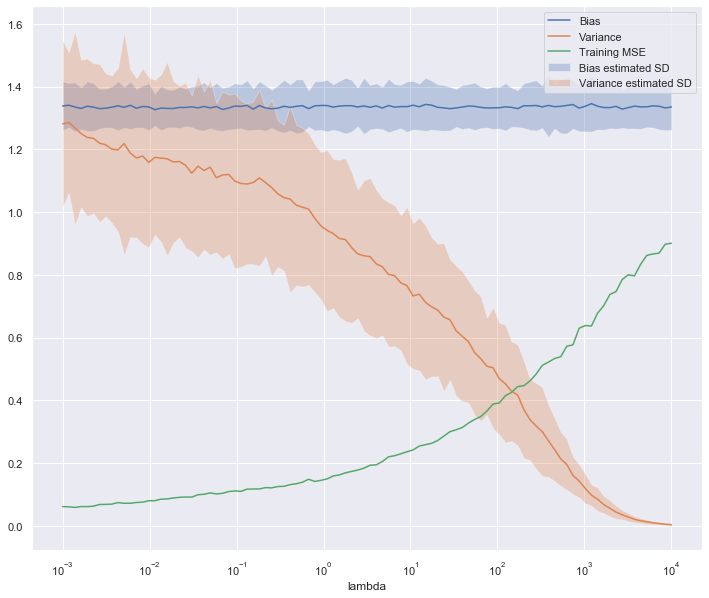

In [16]:
from sklearn.utils import resample
import seaborn as sns
sns.set()

x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
x, y = np.meshgrid(x, y)

sd = 1
scaler = 0.05
z = noisy_franke(x,y, sd, scaler)

poly_degree = 5
bootstrap_n = 100
lambda_n = 100
lambdas = np.logspace(-3, 4, lambda_n)
#lambdas = np.linspace(0, 100, lambda_n)
values = np.arange(lambda_n)


f, ax = plt.subplots(1, 1, figsize=(12, 10))

f1, ax1 = plt.subplots(1, 1, figsize=(12, 10))


train_error = np.zeros(lambda_n)
test_error = np.zeros(lambda_n)
complexity = np.zeros(lambda_n)
test_mse_var = np.zeros(lambda_n)
train_mse_var = np.zeros(lambda_n)
beta_var = np.zeros(lambda_n)
bias = np.zeros(lambda_n)
bias_var = np.zeros(lambda_n)

errors = np.zeros(lambda_n)

variance = np.zeros(lambda_n)
var_var = np.zeros(lambda_n)

polydegree = np.zeros(lambda_n)

################
x = x.ravel()
y = y.ravel()
z = z.ravel()
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2, shuffle=True)



z_scaler = StandardScaler()
z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
z_test = z_scaler.transform(z_test.reshape(-1, 1))

z_train, z_test = z_train.ravel(), z_test.ravel()


for lmbd, idx in zip(lambdas, values):
    mod = RegressionModel()
  
    X_train = mod.polynomial_design(poly_degree, x_train, y_train)
    X_train = mod.scale(X_train)
    X_test = mod.polynomial_design(poly_degree, x_test, y_test)
    X_test = mod.scale(X_test)
 
    

    error = np.zeros(bootstrap_n)
    biases = np.zeros(bootstrap_n)
    variances = np.zeros(bootstrap_n)
    train_mse = np.zeros(bootstrap_n)
    test_mse = np.zeros(bootstrap_n)
    
    #z_hats = np.zeros((len(z_test), bootstrap_n))
    
    for i in range(bootstrap_n):
        X_, z_ = resample(X_train, z_train)
        mod.Ridge_fit(X_, z_, lmbd=lmbd)
        train_MSE = mod.MSE(z_)
        test_MSE = mod.MSE_test(X_test, z_test)
        train_mse[i] = train_MSE
        test_mse[i] = test_MSE
        
        z_preds = mod.predict(X_test)
        
        biases[i] = np.mean((z_test - np.mean(z_preds))**2)
        variances[i] = np.var(z_preds)
        

 
    train_mse_var[idx] = np.var(train_mse)
    test_mse_var[idx] = np.var(test_mse)
    train_error[idx] = np.mean(train_mse)#train_MSE
    test_error[idx] = np.mean(test_mse)#test_MSE 

    
    bias[idx] = np.mean(biases)
    bias_var[idx] = np.var(biases)
    variance[idx] = np.mean(variances)
    var_var[idx] = np.var(variances)
    errors[idx] = np.mean(train_mse)
    

train_mse_var = np.sqrt(train_mse_var) * 2
test_mse_var = np.sqrt(test_mse_var) * 2
bias_var = np.sqrt(bias_var) * 2
var_var = np.sqrt(var_var) * 2

#ax.set_ylim([-50, 50])
ax.set_xscale('log')
ax.plot(lambdas, train_error, label="Bootstrapped Training MSE")
ax.plot(lambdas, test_error, label="Bootstrapped Test MSE")
ax.fill_between(lambdas, train_error+ train_mse_var, train_error - train_mse_var, label="Bootstrapped 2 times SD", alpha=0.3)
ax.fill_between(lambdas, test_error+ test_mse_var, test_error - test_mse_var, label="Bootstrapped 2 times SD", alpha=0.3)
ax.legend()

ax.set_xlabel("lambda")
ax.set_ylabel("MSE")

# second plot
#ax1.set_ylim([-50, 50])
ax1.set_xscale('log')
ax1.plot(lambdas, bias, label="Bias")
ax1.plot(lambdas, variance, label="Variance")
ax1.plot(lambdas, errors, label= "Training MSE")
ax1.fill_between(lambdas, bias + bias_var, bias-bias_var, label="Bias estimated SD", alpha=0.3)
ax1.fill_between(lambdas, variance + var_var, variance-var_var, label="Variance estimated SD", alpha=0.3)
ax1.legend()

ax1.set_xlabel("lambda")
ax1.set_ylabel("")


Here we see that the bootstrap method's estimate of MSE (both test and train) $\textit{increase}$ monotonically with higher values of $\lambda$, suggesting that Ridge regularization is unwarranted for the regression problem posed by fitting the Franke function with a polynomial of fifth degree. Moreover, the bootstrap method illustrates nicely how the variance of the predictions decrease with higher values of $\lambda$ (as we regularize more), and the variance of the estimated variance decreases as well.

### D - b) Cross-validation:

Here we investigate the effect of Ridge regularization on MSE with cross-validation:

In [17]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
x, y = np.meshgrid(x, y)

sd = 1
scaler = 0.05
z = noisy_franke(x,y, sd, scaler)
x = x.ravel()
y = y.ravel()
z = z.ravel()

n = len(z)
k = 5  # five folds
# organize xyz in k random sets:
kn = int(n/k)  # make sure n is divisible by k
indices = np.random.choice(n, size=n, replace=False)

folds = np.zeros((k, kn), dtype=int)
for i in range(k):
    folds[i, :] = indices[i*kn: kn + (i*kn)]

In [18]:
lambda_n = 100
lambdas = np.logspace(-3, 4, lambda_n)
values = np.arange(lambda_n)

MSE_train = np.zeros((k, lambda_n))
MSE_test = np.zeros((k, lambda_n))
poly_degree = 20
for i in range(k):
    x_train = np.delete(x, folds[i, :])
    y_train = np.delete(y, folds[i, :])
    z_train = np.delete(z, folds[i, :])
    
    x_test = x[folds[i, :]]
    y_test = y[folds[i, :]]
    z_test = z[folds[i, :]]
    
    z_scaler = StandardScaler()
    z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
    z_test = z_scaler.transform(z_test.reshape(-1, 1))
    
    z_train, z_test = z_train.ravel(), z_test.ravel()
    
    for lmbd, idx in zip(lambdas, values):
        mod = RegressionModel()

        X_train = mod.polynomial_design(poly_degree, x_train, y_train)
        X_train = mod.scale(X_train)
        X_test = mod.polynomial_design(poly_degree, x_test, y_test)
        X_test = mod.scale(X_test, train=False)
 
        mod.Ridge_fit(X_train, z_train, lmbd=lmbd)
        train_MSE = mod.MSE(z_train)
        test_MSE = mod.MSE_test(X_test, z_test)
        
        MSE_train[i, idx] = train_MSE
        MSE_test[i, idx] = test_MSE 
    

Text(0, 0.5, 'Cross validated MSE')

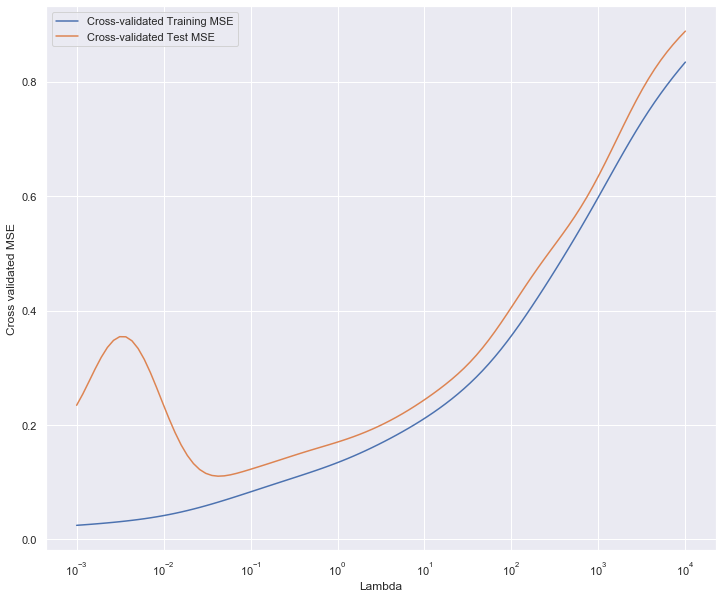

In [19]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

cv_train_error = np.mean(MSE_train, axis = 0)
cv_test_error = np.mean(MSE_test, axis = 0)

ax.set_xscale("log")
ax.plot(lambdas, cv_train_error, label="Cross-validated Training MSE")
ax.plot(lambdas, cv_test_error, label="Cross-validated Test MSE")
ax.legend()
#plt.xticks(np.arange(1, max_poly+1))
plt.xlabel("Lambda")
plt.ylabel("Cross validated MSE")

Here we see that the cross-validation method gives a different estimate of the efficacy of Ridge regularization. Indeed, a 5-fold cross-validation points to an optimal $\lambda$ living in the region of $10^{-2}$.

In [20]:
best_lambda = np.argmin(cv_test_error)
print(lambdas[best_lambda])

0.04229242874389499


### With more polynomials

This effect of regularization on test MSE may only apply to regression models of this type of complexity. Below we consider the effect of $\lambda$ on a range of different polynomial models:

Text(0, 0.5, 'Cross validated MSE')

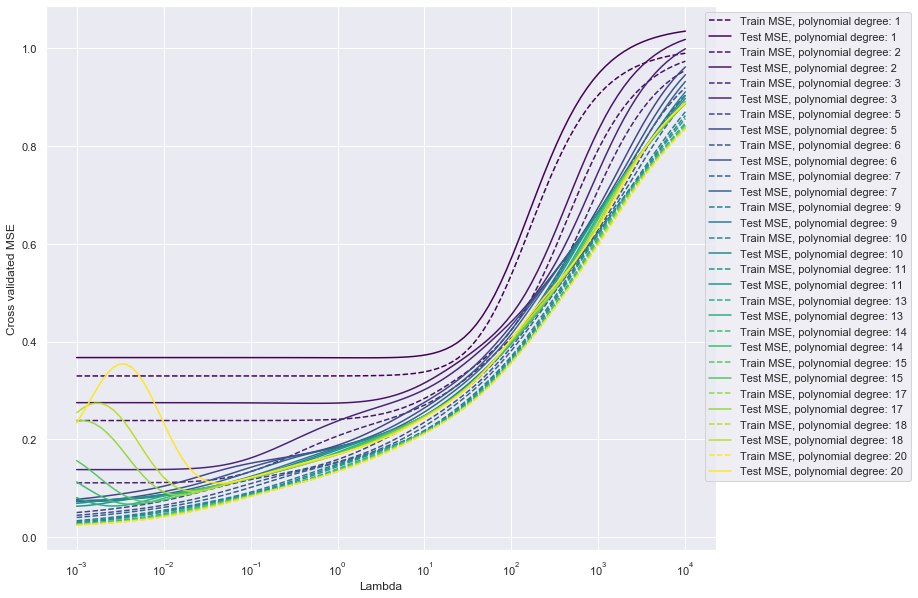

In [21]:
import matplotlib.pylab as pl
lambda_n = 100
lambdas = np.logspace(-3, 4, lambda_n)
values = np.arange(lambda_n)
max_poly = 15
poly_degrees = np.linspace(1, 20, max_poly, dtype=int) 
colors = pl.cm.viridis(np.linspace(0,1,20))


MSE_3d = np.zeros((k, lambda_n, max_poly))

MSE_train = np.zeros((k, lambda_n))
MSE_test = np.zeros((k, lambda_n))
#poly_degree = 20

f, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xscale("log")

for j, poly_degree in enumerate(poly_degrees):
    c = colors[poly_degree - 1]
    for i in range(k):
        x_train = np.delete(x, folds[i, :])
        y_train = np.delete(y, folds[i, :])
        z_train = np.delete(z, folds[i, :])

        x_test = x[folds[i, :]]
        y_test = y[folds[i, :]]
        z_test = z[folds[i, :]]
        
        z_scaler = StandardScaler()
        z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
        z_test = z_scaler.transform(z_test.reshape(-1, 1))
    
        z_train, z_test = z_train.ravel(), z_test.ravel()

        for lmbd, idx in zip(lambdas, values):
            mod = RegressionModel()

            X_train = mod.polynomial_design(poly_degree, x_train, y_train)
            X_train = mod.scale(X_train)
            X_test = mod.polynomial_design(poly_degree, x_test, y_test)
            X_test = mod.scale(X_test, train=False)

            mod.Ridge_fit(X_train, z_train, lmbd=lmbd)
            train_MSE = mod.MSE(z_train)
            test_MSE = mod.MSE_test(X_test, z_test)

            MSE_train[i, idx] = train_MSE
            MSE_test[i, idx] = test_MSE
            
            MSE_3d[i, idx, j] = test_MSE



    cv_train_error = np.mean(MSE_train, axis = 0)
    cv_test_error = np.mean(MSE_test, axis = 0)


    ax.plot(lambdas, cv_train_error, label=f"Train MSE, polynomial degree: {poly_degree}", c = c, ls= "--", linewidth=1.5)
    ax.plot(lambdas, cv_test_error, label=f"Test MSE, polynomial degree: {poly_degree}",  c = c, linewidth=1.5)
ax.legend(bbox_to_anchor=(1.3, 1))
plt.xlabel("Lambda")
plt.ylabel("Cross validated MSE")
    

This graph indicates that the effect of regularization varies with model complexity. Unfortunately, it's hard to discern the exact effect from this plot, so we create a 3D plot as well.

Text(0.5, 0, 'Polynomial')

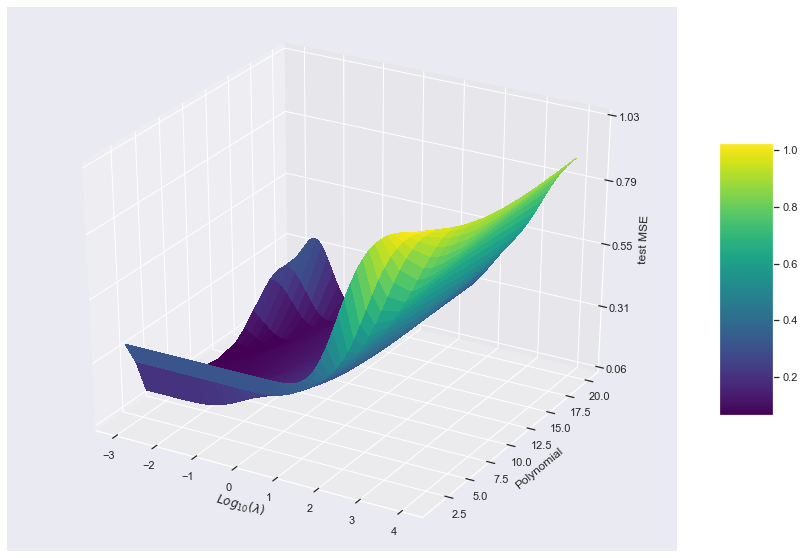

In [22]:

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection="3d")


cv_error = np.mean(MSE_3d, axis= 0)
x_lambda, y_poly = np.meshgrid(lambdas, poly_degrees)
surf = ax.plot_surface(np.log10(x_lambda), y_poly, cv_error.T, cmap=cm.viridis,
linewidth=0, antialiased=False)
# Customize the z axis.

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.set_xscale('log')
ax.set_zlabel("test MSE")
ax.set_xlabel('$Log_{10}(\lambda)$')
ax.set_ylabel('Polynomial')

Here we see test MSE for different $\lambda$ values, for different model complexities. When we do model selection, we would seek to find the minimum of such a plane. 

## Part e)

Here we repeat the analysis performed above for Ridge regularization, with Lasso regularization. We use slightly lower $\lambda$ values.

In [23]:
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
x, y = np.meshgrid(x, y)

sd = 1
scaler = 0.05
z = noisy_franke(x,y, sd, scaler)
x = x.ravel()
y = y.ravel()
z = z.ravel()

n = len(z)
k = 5  # five folds
# organize xyz in k random sets:
kn = int(n/k)  # make sure n is divisible by k
indices = np.random.choice(n, size=n, replace=False)

folds = np.zeros((k, kn), dtype=int)
for i in range(k):
    folds[i, :] = indices[i*kn: kn + (i*kn)]

In [24]:
lambda_n = 100
lambdas = np.logspace(-6, 1, lambda_n)
values = np.arange(lambda_n)
MSE_train = np.zeros((k, lambda_n))
MSE_test = np.zeros((k, lambda_n))
poly_degree = 20
for i in range(k):
    x_train = np.delete(x, folds[i, :])
    y_train = np.delete(y, folds[i, :])
    z_train = np.delete(z, folds[i, :])
    
    x_test = x[folds[i, :]]
    y_test = y[folds[i, :]]
    z_test = z[folds[i, :]]
    
    z_scaler = StandardScaler()
    z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
    z_test = z_scaler.transform(z_test.reshape(-1, 1))
    
    z_train, z_test = z_train.ravel(), z_test.ravel()
    
    for lmbd, idx in zip(lambdas, values):
        mod = RegressionModel()

        X_train = mod.polynomial_design(poly_degree, x_train, y_train)
        X_train = mod.scale(X_train)
        X_test = mod.polynomial_design(poly_degree, x_test, y_test)
        X_test = mod.scale(X_test, train=False)
 
        mod.Lasso_fit(X_train, z_train, lmbd=lmbd)
        train_MSE = mod.MSE(z_train)
        test_MSE = mod.MSE_test(X_test, z_test)
        
        MSE_train[i, idx] = train_MSE
        MSE_test[i, idx] = test_MSE 
    

Text(0, 0.5, 'Cross validated MSE')

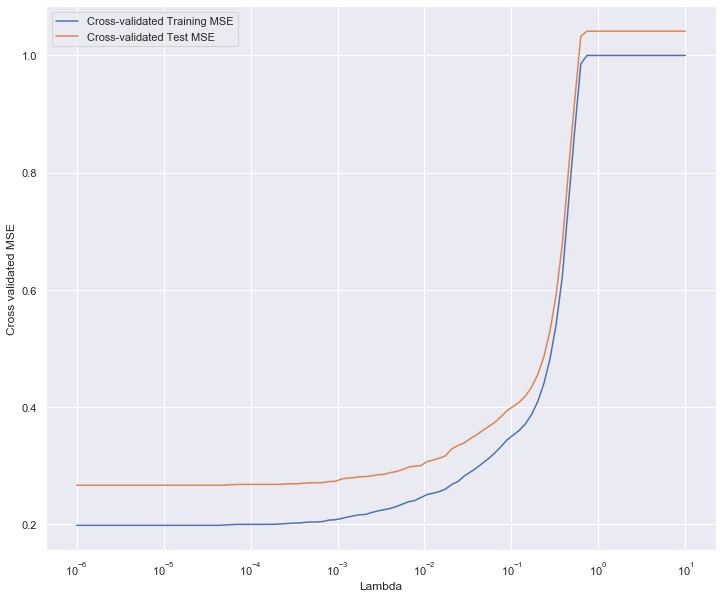

In [25]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))

cv_train_error = np.mean(MSE_train, axis = 0)
cv_test_error = np.mean(MSE_test, axis = 0)

ax.set_xscale("log")
ax.plot(lambdas, cv_train_error, label="Cross-validated Training MSE")
ax.plot(lambdas, cv_test_error, label="Cross-validated Test MSE")
ax.legend()
#plt.xticks(np.arange(1, max_poly+1))
plt.xlabel("Lambda")
plt.ylabel("Cross validated MSE")

Here we see the effect of Lasso regularization on train and test MSE. Both seem to increase with $\lambda$ up to a certain point, where the increase of $\lambda$ has no more bearings on MSE. This is probably due to the high $\lambda$ having discarded all other model parameters except for the intercept, thus having applied the maximum possible amount of regularization.

Now we investigate whether this effect holds for more and less complex models as well.

Text(0, 0.5, 'Cross validated MSE')

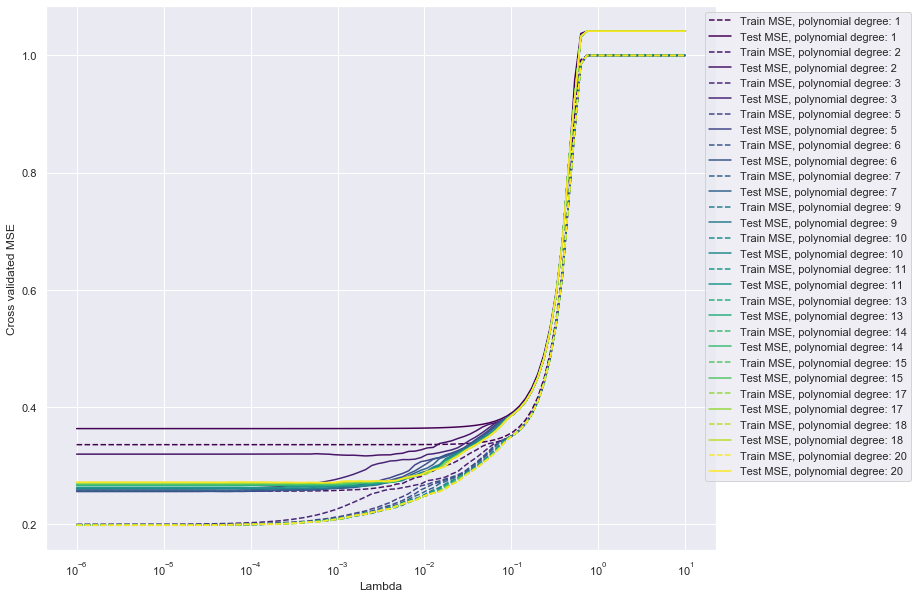

In [26]:
import matplotlib.pylab as pl
lambda_n = 100
lambdas = np.logspace(-6, 1, lambda_n)
values = np.arange(lambda_n)
max_poly = 15
poly_degrees = np.linspace(1, 20, max_poly, dtype=int) 
colors = pl.cm.viridis(np.linspace(0,1,20))


MSE_3d = np.zeros((k, lambda_n, max_poly))

MSE_train = np.zeros((k, lambda_n))
MSE_test = np.zeros((k, lambda_n))


f, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_xscale("log")

for j, poly_degree in enumerate(poly_degrees):
    c = colors[poly_degree - 1]
    for i in range(k):
        x_train = np.delete(x, folds[i, :])
        y_train = np.delete(y, folds[i, :])
        z_train = np.delete(z, folds[i, :])

        x_test = x[folds[i, :]]
        y_test = y[folds[i, :]]
        z_test = z[folds[i, :]]
        
        z_scaler = StandardScaler()
        z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
        z_test = z_scaler.transform(z_test.reshape(-1, 1))
    
        z_train, z_test = z_train.ravel(), z_test.ravel()

        for lmbd, idx in zip(lambdas, values):
            mod = RegressionModel()

            X_train = mod.polynomial_design(poly_degree, x_train, y_train)
            X_train = mod.scale(X_train)
            X_test = mod.polynomial_design(poly_degree, x_test, y_test)
            X_test = mod.scale(X_test)

            mod.Lasso_fit(X_train, z_train, lmbd=lmbd)
            train_MSE = mod.MSE(z_train)
            test_MSE = mod.MSE_test(X_test, z_test)

            MSE_train[i, idx] = train_MSE
            MSE_test[i, idx] = test_MSE
            
            MSE_3d[i, idx, j] = test_MSE



    cv_train_error = np.mean(MSE_train, axis = 0)
    cv_test_error = np.mean(MSE_test, axis = 0)


    ax.plot(lambdas, cv_train_error, label=f"Train MSE, polynomial degree: {poly_degree}", c = c, ls= "--", linewidth=1.5)
    ax.plot(lambdas, cv_test_error, label=f"Test MSE, polynomial degree: {poly_degree}",  c = c, linewidth=1.5)
ax.legend(bbox_to_anchor=(1.3, 1))

plt.xlabel("Lambda")
plt.ylabel("Cross validated MSE")
    

Here we can see that all complexities are prone to discarding all parameters except the intercept with a high enough value of $\lambda$, however, how the MSE changes with regularization is still quite different for differing model complexities. This can also be discerned with the 3d plot:

Text(0.5, 0, 'Polynomial')

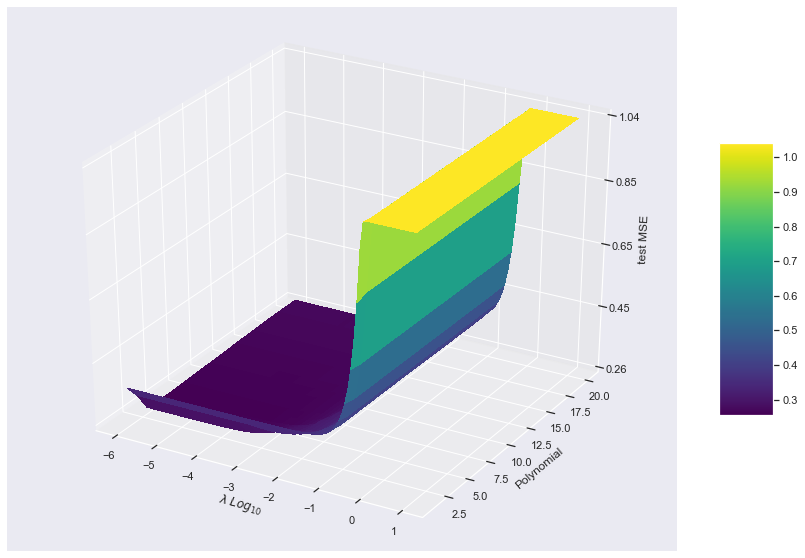

In [27]:

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection="3d")


cv_error = np.mean(MSE_3d, axis= 0)
x_lambda, y_poly = np.meshgrid(lambdas, poly_degrees)
surf = ax.plot_surface(np.log10(x_lambda), y_poly, cv_error.T, cmap=cm.viridis,
linewidth=0, antialiased=False)
# Customize the z axis.

ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlabel("test MSE")
ax.set_xlabel('$\lambda$ $Log_{10}$')
ax.set_ylabel('Polynomial')

## Part g)

Here we analyze the terrain data. We prepare it and create a helper class called $\texttt{PolynomialModelSelector}$ which streamlines the model selection process. We look at fits and predictions for OLS, Ridge and Lasso applied to the terrain data, using 5-fold cross-validation.

Create the $\texttt{PolynomialModelSelector}$ classe:

In [28]:
class PolynomialModelSelector():
    
    def __init__(self, x, y, z, original_z):
        
        self.x = x
        self.y = y
        self.z = z
        self.n = len(self.z)
        self.has_folds = False
        self.original_z = original_z
    
    
    def cross_validate_OLS(self, k, polynomials, plot = False):
        if not self.has_folds:
            self.create_folds(k)
            
        mod = RegressionModel()
        losses = np.zeros((k, len(polynomials)))
        
        for j, poly_degree in enumerate(polynomials):
            
            for i in range(k):
                x_train = np.delete(self.x, folds[i, :])
                y_train = np.delete(self.y, folds[i, :])
                z_train = np.delete(self.z, folds[i, :])

                x_test = self.x[folds[i, :]]
                y_test = self.y[folds[i, :]]
                z_test = self.z[folds[i, :]]
                
                z_scaler = StandardScaler()
                z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
                z_test = z_scaler.transform(z_test.reshape(-1, 1))
            
                z_train, z_test = z_train.ravel(), z_test.ravel()


                
                X_train = mod.polynomial_design(poly_degree, x_train, y_train)
                X_train = mod.scale(X_train)
                X_test = mod.polynomial_design(poly_degree, x_test, y_test)
                X_test = mod.scale(X_test, train = False)
                
        
                mod.OLS_fit(X_train, z_train)
                train_MSE = mod.MSE(z_train)
                test_MSE = mod.MSE_test(X_test, z_test)

                losses[i, j] = test_MSE
                
        cv_error = np.mean(losses, axis=0)
        best_poly_idx = np.argmin(cv_error)
        best_cv_error = cv_error[best_poly_idx]
        best_poly = polynomials[best_poly_idx]
        
        
        if plot:
            best_model = RegressionModel()
            X = best_model.polynomial_design(best_poly, self.x, self.y)
            X = best_model.scale(X)
            best_model.OLS_fit(X, self.z)
            z_preds = best_model.y_tilde
            f, ax = plt.subplots(1, 1, figsize=(10, 8))
            ax.imshow(z_preds.reshape(self.original_z.shape[0], self.original_z.shape[1]), cmap='coolwarm')
        return best_poly, best_cv_error
    
    
    def cross_validate_penalized(self, k, polynomials, lambdas, penalization = "ridge", plot=False):
        mod = RegressionModel()
        
        if penalization == "ridge":
            fit = mod.Ridge_fit
        else:
            fit = mod.Lasso_fit
        
        
        if not self.has_folds:
            self.create_folds(k)
        
        losses = np.zeros((k, len(lambdas), len(polynomials)))
        values = np.arange(len(lambdas))
        for j, poly_degree in enumerate(polynomials):
            
            for i in range(k):
                x_train = np.delete(x, folds[i, :])
                y_train = np.delete(y, folds[i, :])
                z_train = np.delete(z, folds[i, :])

                x_test = x[folds[i, :]]
                y_test = y[folds[i, :]]
                z_test = z[folds[i, :]]
                
                z_scaler = StandardScaler()
                z_train = z_scaler.fit_transform(z_train.reshape(-1, 1))
                z_test = z_scaler.transform(z_test.reshape(-1, 1))
            
                z_train, z_test = z_train.ravel(), z_test.ravel()

                for lmbd, idx in zip(lambdas, values):
                    

                    X_train = mod.polynomial_design(poly_degree, x_train, y_train)
                    X_train = mod.scale(X_train)
                    X_test = mod.polynomial_design(poly_degree, x_test, y_test)
                    X_test = mod.scale(X_test, train =False)

                    fit(X_train, z_train, lmbd=lmbd)
                    train_MSE = mod.MSE(z_train)
                    test_MSE = mod.MSE_test(X_test, z_test)

                    #MSE_train[i, idx] = train_MSE
                    #MSE_test[i, idx] = test_MSE

                    losses[i, idx, j] = test_MSE


                
        cv_error = np.mean(losses, axis=0)
        best_idx = np.where(cv_error==np.min(cv_error))
        best_cv_error = cv_error[best_idx].squeeze()
        best_poly = polynomials[best_idx[1].squeeze()]
        best_lambda = lambdas[best_idx[0].squeeze()]
        
        if plot:
            best_model = RegressionModel()
            X = best_model.polynomial_design(best_poly, self.x, self.y)
            X = best_model.scale(X)
            if penalization == "ridge":
                best_model.Ridge_fit(X, self.z, best_lambda)
            else:
                best_model.Lasso_fit(X, self.z, best_lambda)
            z_preds = best_model.y_tilde
            f, ax = plt.subplots(1, 1, figsize=(10, 8))
            ax.imshow(z_preds.reshape(self.original_z.shape[0], self.original_z.shape[1]), cmap='coolwarm')
        
        return best_poly, best_lambda, best_cv_error
        
    def create_folds(self, k):
        
        kn = int(self.n/k)
        indices = np.random.choice(self.n, size=self.n, replace=False)

        self.folds = np.zeros((k, kn), dtype=int)
        for i in range(k):
            self.folds[i, :] = indices[i*kn: kn + (i*kn)]
    


Load and prepare the terrain data:

Text(0, 0.5, 'Y')

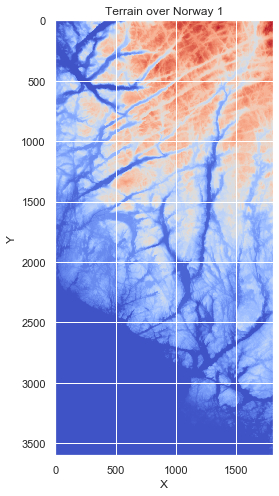

In [29]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('SRTM_data_Norway_2.tif')
# Show the terrain
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Terrain over Norway 1')
ax.imshow(terrain1, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [30]:
y = np.linspace(0, 1, terrain1.shape[0])
x = np.linspace(0, 1, terrain1.shape[1])
x, y = np.meshgrid(x, y)
x, y = x.ravel(), y.ravel()
z = terrain1.ravel()


### OLS

Here we obtain the OLS fit using a polynomial of fifth degree. The model selector can search through and find the best fit given an array of polynomials, but since the terrain data set is so large, and evaluating regression models will be very time consuming, we restrict the search space to include polynomials up to 8th degree. 

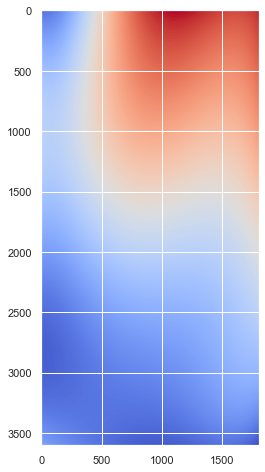

In [31]:
max_poly = 8
max_poly_nr = 8
poly_degrees = np.linspace(1, max_poly, max_poly_nr, dtype=int)

model_selector = PolynomialModelSelector(x, y, z, terrain1) # initialize with data
best_poly_fit, mse = model_selector.cross_validate_OLS(k=2, polynomials = poly_degrees, plot=True)


In [32]:
print(best_poly_fit, mse)

5 0.0004128095752222899


This is the fit (visualized above) and the test MSE obtained from using the polynomial degree which minimized test MSE. Now we look at the same minimization problem with Ridge and Lasso regression.

### Ridge

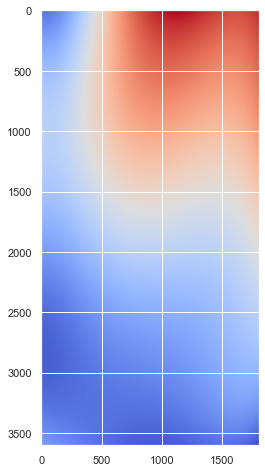

In [33]:
# Ridge regression
poly_degrees = [5]  # consider only polynomial of fifth degree
lmbd = [0.2] # consider only lambda =0.2
model_selector = PolynomialModelSelector(x, y, z, terrain1) # initialize with data
best_poly_fit, best_lambda, mse = model_selector.cross_validate_penalized(k=2, polynomials = poly_degrees, penalization = "ridge",
                                                             lambdas = lmbd, plot=True)


In [34]:
print(mse)

0.0004454054999846309


### Lasso

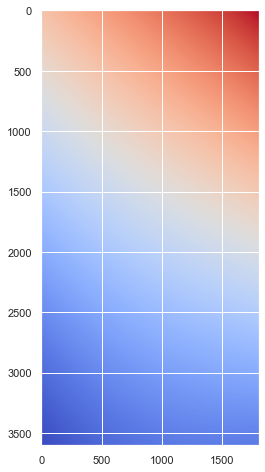

In [35]:
# Lasso regression
poly_degrees = [5]  # consider only polynomial of fifth degree
lmbd = [0.2] # consider only lambda =0.2
model_selector = PolynomialModelSelector(x, y, z, terrain1) # initialize with data
best_poly_fit, best_lambda, mse = model_selector.cross_validate_penalized(k=2, polynomials = poly_degrees, penalization = "lasso",
                                                             lambdas = lmbd, plot=True)


In [36]:
print(mse)

3.7539566100392916


We can see that Lasso regression performs significantly worse than Ridge and OLS, because it applies too much regularization and ends up missing important non-linear structures in the data set. Consequently, the plottet function displays a higher degree of smoothness and linearity than those obtained from Ridge and OLS. 